**the dataset itself conatins multiple csv files and all the columns match each other so all ww have to do is store each file in a DataFrame and join them together**

In [2]:
import pandas as pd
import numpy as np
# tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


In [3]:
import os
import pandas as pd

# Path to the directory containing your dataset files in Kaggle
directory = "/kaggle/input/network-intrusion-dataset"

# Initialize an empty list to store individual dataframes
dataframes = []

# Iterate through all files in the directory
for file in os.listdir(directory):
    if file.endswith(".csv"):
        # Construct full file path
        file_path = os.path.join(directory, file)
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        # Strip leading/trailing spaces from all column names
        df.columns = df.columns.str.strip()
        # Append the dataframe to the list
        dataframes.append(df)

# Concatenate all dataframes into a single dataframe
finaldf = pd.concat(dataframes, ignore_index=True)

# Save the combined dataframe to a CSV file in Kaggle's output directory
output_path = "/kaggle/working/combined_network_intrusion.csv"
finaldf.to_csv(output_path, index=False)

# Verify column names after standardization
print(finaldf.columns)





Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [4]:
# Optional: Display first few rows of the combined dataframe
print(finaldf.head())

   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0                22        1266342                 41                      44   
1                22        1319353                 41                      44   
2                22            160                  1                       1   
3                22        1303488                 41                      42   
4             35396             77                  1                       2   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                         2664                         6954   
1                         2664                         6954   
2                            0                            0   
3                         2728                         6634   
4                            0                            0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                    456                      0            

**the target variable is the Columns 'label' which contains only multiple classification such as benign, Brute Force etc**

In [5]:
finaldf.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [6]:
# Display the 'Label' column
print(finaldf['Label'].unique())


['BENIGN' 'PortScan' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DDoS' 'Bot'
 'Infiltration' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk'
 'DoS GoldenEye' 'Heartbleed']


**there are many types of attack types mentioned in the column. since this project is for binary classification we will replace every value that does not say BENIGN with ATTACK**

In [7]:
# Ensure column names are cleaned to remove leading spaces
finaldf.columns = finaldf.columns.str.strip()

# Replace values in the 'Label' column
finaldf['Label'] = finaldf['Label'].apply(lambda x: 'ATTACK' if x != 'BENIGN' else x)

# Check the updated 'Label' column
print(finaldf['Label'].value_counts())


Label
BENIGN    2273097
ATTACK     557646
Name: count, dtype: int64


**Removing BENIGN with 1 and ATTACK with 0**

In [8]:
finaldf['Label'] = finaldf['Label'].apply(lambda x: 1 if x == 'ATTACK' else 0)
print(finaldf['Label'].unique())

[0 1]


In [9]:
# Replace inf/-inf with NaN
finaldf.replace([float('inf'), float('-inf')], float('nan'), inplace=True)

finaldf.fillna(0, inplace=True)  # Replace NaN with 0

# Convert dataframe to integers
finaldf = finaldf.astype(int)

# Verify the conversion
print(finaldf.dtypes)


Destination Port               int64
Flow Duration                  int64
Total Fwd Packets              int64
Total Backward Packets         int64
Total Length of Fwd Packets    int64
                               ...  
Idle Mean                      int64
Idle Std                       int64
Idle Max                       int64
Idle Min                       int64
Label                          int64
Length: 79, dtype: object


In [10]:
X=finaldf.drop('Label', axis=1)
Y=finaldf['Label']

In [11]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

**the following code took about half an hour on my i5 8gen, if you wan to save time you can use PCA or any other techniques to select only those columns which contribute to the output**

In [17]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold


# Impute missing values (replace NaNs with the mean)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Replace NaN and infinite values with 0
X_imputed = np.nan_to_num(X_imputed)
X_imputed = np.where(np.isinf(X_imputed), 0, X_imputed)

# Step 1: Remove low-variance features
variance_threshold = 1e-2  # Adjust threshold to control feature removal
selector = VarianceThreshold(threshold=variance_threshold)
X_reduced = selector.fit_transform(X_imputed)

print("Shape after removing low-variance features:", X_reduced.shape)

# Step 2: Perform feature selection using SelectKBest
# Ensure Y is numeric
Y = pd.to_numeric(Y, errors='coerce')

# Set the number of features to select
k = min(20, X_reduced.shape[1])  # Select top 20 features or fewer if fewer columns remain

# Initialize SelectKBest with mutual_info_classif
k_best = SelectKBest(score_func=mutual_info_classif, k=k)

# Fit and transform to select top features
X_new = k_best.fit_transform(X_reduced, Y)

print("Shape of selected features after SelectKBest:", X_new.shape)

# Step 3: Get selected feature names
selected_features_mask = k_best.get_support()  # Boolean mask for selected features
selected_feature_indices = np.where(selected_features_mask)[0]
reduced_columns = np.array(X.columns)[selector.get_support()]  # Columns left after VarianceThreshold
selected_feature_names = reduced_columns[selected_feature_indices]

print("Selected feature names:", selected_feature_names)

Shape after removing low-variance features: (2830743, 66)
Shape of selected features after SelectKBest: (2830743, 20)
Selected feature names: ['Destination Port' 'Flow Duration' 'Total Length of Fwd Packets'
 'Total Length of Bwd Packets' 'Fwd Packet Length Max'
 'Bwd Packet Length Max' 'Bwd Packet Length Mean' 'Flow Bytes/s'
 'Flow IAT Max' 'Fwd IAT Max' 'Max Packet Length' 'Packet Length Mean'
 'Packet Length Std' 'Packet Length Variance' 'Average Packet Size'
 'Avg Bwd Segment Size' 'Subflow Fwd Bytes' 'Subflow Bwd Bytes'
 'Init_Win_bytes_forward' 'Init_Win_bytes_backward']


In [18]:
selected_features_mask = k_best.get_support()
print(selected_features_mask)

[ True  True False False  True  True  True False False False  True False
  True False  True False False False  True False False False False  True
 False False False False False False False False False False False False
  True  True  True  True False False False False False False  True False
  True False False  True False  True  True  True False False False False
 False False False False False False]


In [19]:
elected_feature_names = X.columns[selected_features_mask]
elected_feature_names

Index(['Destination Port', 'Flow Duration', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Flow Bytes/s',
       'Flow IAT Max', 'Fwd IAT Max', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Average Packet Size', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes',
       'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward'],
      dtype='object')

In [20]:
new_columns=['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std',
       'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'Average Packet Size',
       'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min']
df_new=X[new_columns]


In [21]:
df_new['label']=finaldf['Label']
df_new

<ipython-input-21-af8cc4889594>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['label']=finaldf['Label']


,Flow Duration,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow IAT Std,Flow IAT Max,Fwd IAT Total,Fwd IAT Std,Fwd IAT Max,...,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Bwd Segment Size,Idle Mean,Idle Max,Idle Min,label
0,1266342.0,976.0,0.0,158.0,312.0,104051.0,948537.0,1266342.0,159355.0,996324.0,...,976.0,111.0,239.0,57449.0,113.0,158.0,0.0,0.0,0.0,0
1,1319353.0,976.0,0.0,158.0,312.0,104861.0,955790.0,1319353.0,159247.0,996423.0,...,976.0,111.0,239.0,57449.0,113.0,158.0,0.0,0.0,0.0,0
2,160.0,0.0,0.0,0.0,0.0,0.0,160.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1303488.0,976.0,0.0,157.0,319.0,106554.0,956551.0,1303488.0,160397.0,997357.0,...,976.0,111.0,241.0,58391.0,112.0,157.0,0.0,0.0,0.0,0
4,77.0,0.0,0.0,0.0,0.0,14.0,49.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,32215.0,76.0,76.0,76.0,0.0,13617.0,30780.0,30832.0,17755.0,30780.0,...,76.0,41.0,23.0,548.0,48.0,76.0,0.0,0.0,0.0,0
2830739,324.0,181.0,181.0,181.0,0.0,183.0,320.0,2.0,0.0,2.0,...,181.0,97.0,76.0,5796.0,122.0,181.0,0.0,0.0,0.0,0
2830740,82.0,6.0,6.0,6.0,0.0,52.0,78.0,4.0,0.0,4.0,...,31.0,17.0,16.0,267.0,22.0,6.0,0.0,0.0,0.0,0
2830741,1048635.0,128.0,128.0,128.0,0.0,375521.0,1000947.0,1033613.0,444210.0,1000947.0,...,128.0,53.0,42.0,1792.0,60.0,128.0,0.0,0.0,0.0,0


In [22]:
X1=df_new.iloc[:,:-1].values
y1=df_new.iloc[:,-1].values


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_test.shape, y_test.shape

((849223, 20), (849223,))

In [24]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class BinaryClassificationModel:
    def __init__(self, numerical_feature_count):
        """
        Initializes the BinaryClassificationModel class.
        
        :param numerical_feature_count: Number of numerical features.
        """
        self.numerical_feature_count = numerical_feature_count
        self.model = self._build_model()

    def _build_model(self):
        """
        Builds the TensorFlow model for binary classification tasks.
        
        :return: Compiled TensorFlow model.
        """
        # Numerical input
        numerical_input = Input(shape=(self.numerical_feature_count,), name="numerical_input")
        x = BatchNormalization()(numerical_input)  # Normalize numerical inputs

        # Fully connected layers with ReLU activation and Dropout
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)

        # Output layer for binary classification
        output = Dense(1, activation='sigmoid', name="output")(x)

        # Create and compile model
        model = Model(inputs=numerical_input, outputs=output)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model

    def summary(self):
        """Prints the summary of the model."""
        self.model.summary()

# Initialize model
numerical_feature_count = 20  # Replace with the actual number of numerical features in your dataset
model = BinaryClassificationModel(numerical_feature_count).model
model.summary()

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)         │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,137 (51.32 KB)

 Trainable params: 13,097 (51.16 KB)

 Non-trainable params: 40 (160.00 B)

## Training the model

In [25]:
history = model.fit(
    X_train,  # Replace with your training feature data
    y_train,  # Replace with your binary target data
    validation_data=(X_test, y_test),  # Use your test data for validation
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
61923/61923 ━━━━━━━━━━━━━━━━━━━━ 133s 2ms/step - accuracy: 0.8954 - loss: 0.2242 - val_accuracy: 0.9054 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 2/20
61923/61923 ━━━━━━━━━━━━━━━━━━━━ 121s 2ms/step - accuracy: 0.9082 - loss: 0.1939 - val_accuracy: 0.9317 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 3/20
61923/61923 ━━━━━━━━━━━━━━━━━━━━ 121s 2ms/step - accuracy: 0.9101 - loss: 0.1893 - val_accuracy: 0.9302 - val_loss: 0.1635 - learning_rate: 0.0010
Epoch 4/20
61923/61923 ━━━━━━━━━━━━━━━━━━━━ 122s 2ms/step - accuracy: 0.9108 - loss: 0.1878 - val_accuracy: 0.9071 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 5/20
61923/61923 ━━━━━━━━━━━━━━━━━━━━ 121s 2ms/step - accuracy: 0.9113 - loss: 0.1864 - val_accuracy: 0.9055 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 6/20
61923/61923 ━━━━━━━━━━━━━━━━━━━━ 122s 2ms/step - accuracy: 0.9117 - loss: 0.1859 - val_accuracy: 0.9327 - val_loss: 0.1643 - learning_rate: 0.0010
Epoch 7/20
61923/61923 ━━━━━━━━━━━━━━━━━━━━ 121s 2ms

In [27]:
model.save('Intrusion Detction model.h5')  # Save the model to a file


In [28]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



26539/26539 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - accuracy: 0.9329 - loss: 0.1632
Test Loss: 0.1611975133419037
Test Accuracy: 0.9327844381332397


In [30]:
from sklearn.metrics import accuracy_score

# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert predictions to binary (0 or 1)

# Evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


26539/26539 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
Accuracy: 0.9327844394228607


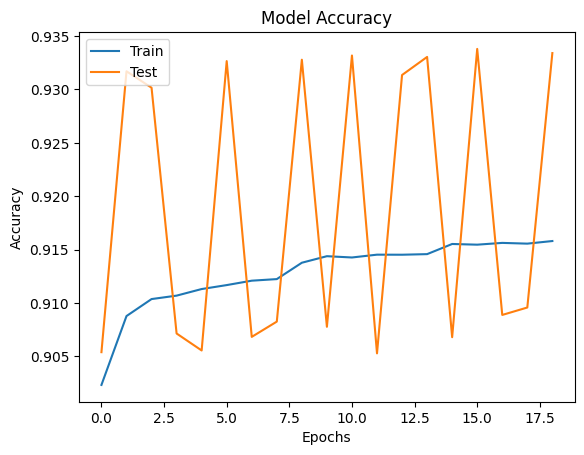

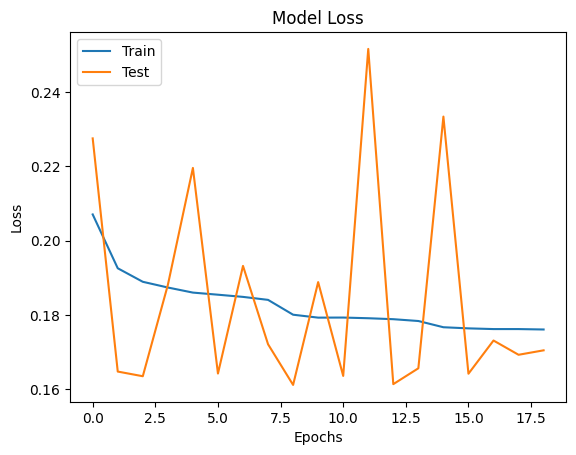

Final Training Loss (jtrain): 0.1761159896850586
Final Validation Loss (jv): 0.1705075353384018
The model might be underfitting (High Bias).


In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Bias/Variance Analysis based on loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Final loss values
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

print("Final Training Loss (jtrain):", final_train_loss)
print("Final Validation Loss (jv):", final_val_loss)

# Bias/Variance Evaluation
if final_train_loss < final_val_loss:
    print("The model is likely overfitting (High Variance).")
elif final_train_loss > final_val_loss:
    print("The model might be underfitting (High Bias).")
else:
    print("The model seems to have an appropriate fit.")
